In [14]:
import matplotlib.pyplot as plt
import numpy as np

from skimage.feature import hog
from skimage import data, exposure
from skimage.color import rgb2gray
from skimage.io import imread
from skimage.transform import resize

from keras.preprocessing import image

import pandas as pd

# Hide all warnings
import warnings
warnings.filterwarnings('ignore')

import nltk

df = pd.read_csv("../visualstories_edfest_2016_twitter_xmedia.csv", sep=';', encoding="utf-8")

data = np.array([df.get("text").values, df.get("image-url").values])
tweets = data[0]
imageLinks = data[1]

# Bad resulsts
#from nltk.tokenize import TreebankWordTokenizer
#tknzr = TreebankWordTokenizer()

# Good results but doesn't have method to remove links
#from nltk.tokenize import TweetTokenizer
#tknzr = TweetTokenizer(strip_handles=True, preserve_case=False)

# Very Good Resulsts, probably because urls and handles are removed
from tokenizer import tokenizer
tknzr = tokenizer.TweetTokenizer(preserve_handles=False, preserve_case=False, preserve_url=False)

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words="english", min_df=3, binary=False, tokenizer=tknzr.tokenize)
texts_bow = vectorizer.fit_transform(tweets)
vocabulary = vectorizer.vocabulary_
print("Vocabulary size: {}".format(len(vocabulary)))

from sklearn.metrics import pairwise_distances

def k_neighbours(q, X, metric="euclidean", k=10):
    # Check pairwise_distances function docs: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html#sklearn.metrics.pairwise_distances
    dists = pairwise_distances(q, X, metric=metric)
    
    # Dists gets a shape 1 x NumDocs. Convert it to shape NumDocs (i.e. drop the first dimension)
    dists = np.squeeze(dists)
    sorted_indexes = np.argsort(dists)
    
    return sorted_indexes[:k], dists[sorted_indexes[:k]]

from sklearn.preprocessing import normalize
texts_bow = normalize(texts_bow, norm="l2")

query1 = "Street circus a popular attractions at Edfest attracting several artists such as unicycle juggling."
query=query1

# Transform query in a BoW representation
query_bow = vectorizer.transform([query])
query_bow = normalize(query_bow, norm="l2")

k_nearest_indexes, k_nearest_dists = k_neighbours(q=query_bow, X=texts_bow, metric="cosine", k=10)

list(zip(k_nearest_indexes,k_nearest_dists, [tweets[i] for i in k_nearest_indexes],[imageLinks[i] for i in k_nearest_indexes]))

Vocabulary size: 1008


[(471,
  0.43305329048615904,
  '#edfringe 2016 Utilising the street. Mime artist. pic.twitter.com/tG00OdQXGv',
  'https://pbs.twimg.com/media/CqVDTy8WgAAIVnQ.jpg'),
 (707,
  0.5,
  'My wanderings took me to Circus Lane today.  #edinphoto #edfringe pic.twitter.com/R0IqB0RD4q',
  'https://pbs.twimg.com/media/CpsHUAPWAAA72xw.jpg'),
 (473,
  0.525658350974743,
  '#edfringe 2016 A mime artist working the street. Talented guy. pic.twitter.com/s7hBCdq7kt',
  'https://pbs.twimg.com/media/CqU749nXEAIr2YU.jpg'),
 (1363,
  0.525658350974743,
  '@BryanCJewett awesome set for EDFest man. Enjoyed every minute.  pic.twitter.com/oQVVd7csji',
  'https://pbs.twimg.com/media/CzTVr3KWEAEyBk2.jpg'),
 (609,
  0.525658350974743,
  'Brass Monkey. Booze. On beds. #edfringe pic.twitter.com/wCkoJ73Fpi',
  'https://pbs.twimg.com/media/CpbfJrzWcAE8kxe.jpg'),
 (67,
  0.5477329831333546,
  'Greasiest greasy spoon ever. Literally dripping. Noms. #edfringe pic.twitter.com/c6afWwlSUd',
  'https://pbs.twimg.com/media/C

## <a name="head22"></a> Histogram of Colors

Shape of feature matrix: (2000, 64)
Image query feature dimension: (64,)
Query image: 765986455512645632.jpg


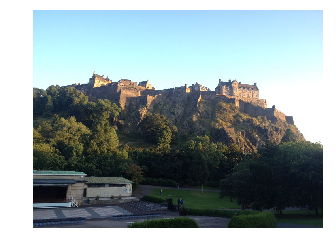

Image #0 - distance: 0.07004896177584419


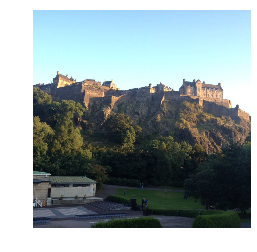

Image #1 - distance: 0.44361573293756196


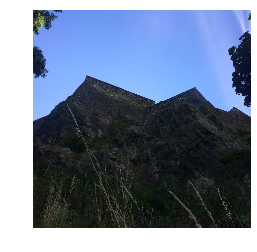

Image #2 - distance: 0.47419408500569066


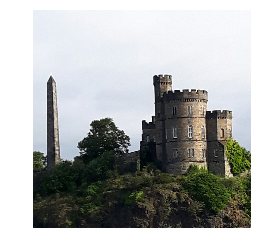

Image #3 - distance: 0.4946686290736531


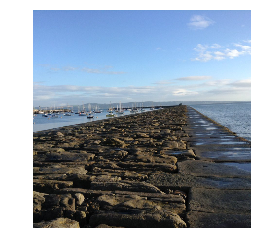

Image #4 - distance: 0.5041657493778583


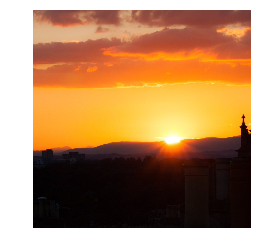

Image #5 - distance: 0.5440935107889279


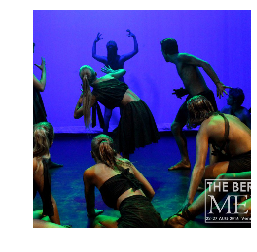

Image #6 - distance: 0.5469342718917318


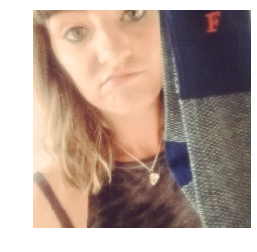

Image #7 - distance: 0.5664133135197242


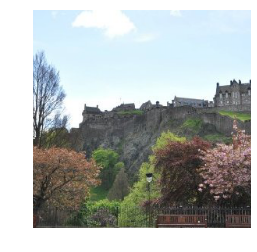

Image #8 - distance: 0.5741614632856872


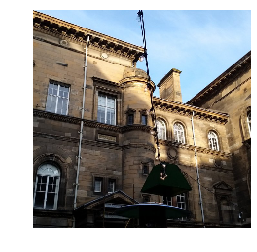

Image #9 - distance: 0.5744248568967968


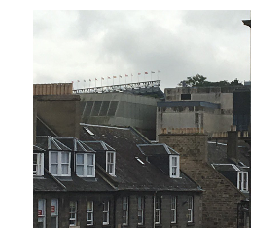

In [15]:

from skimage import img_as_ubyte
from sklearn.preprocessing import normalize
from skimage import color



def center_crop_image(im, size=224):

    if im.shape[2] == 4: # Remove the alpha channel
        im = im[:, :, 0:3]

    # Resize so smallest dim = 224, preserving aspect ratio
    h, w, _ = im.shape
    if h < w:
        im = resize(image=im, output_shape=(224, int(w * 224 / h)))
    else:
        im = resize(im, (int(h * 224 / w), 224))

    # Center crop to 224x224
    h, w, _ = im.shape
    im = im[h // 2 - 112:h // 2 + 112, w // 2 - 112:w // 2 + 112]
    
    return im

def hoc(im, bins=(16,16,16), hist_range=(256, 256, 256)):
    im_r = im[:,:,0]
    im_g = im[:,:,1]
    im_b = im[:,:,2]
    
    red_level = hist_range[0] / bins[0]
    green_level = hist_range[1] / bins[1]
    blue_level = hist_range[2] / bins[2]
    
    im_red_levels = im_r / red_level
    im_green_levels = im_g / green_level
    im_blue_levels = im_b / blue_level
    
    ind = im_blue_levels*bins[0]*bins[1]+ im_green_levels*bins[0] + im_red_levels
    
    hist_r, bins_r = np.histogram(ind.flatten(), bins[0]*bins[1]*bins[2])
    
    return hist_r, bins_r




#Histogram of colors results
feats = []

#Test with diferent bins
bins=(4,4,4)

for img in imageLinks:
    
    #Alter image links to images folder
    img = imread(img.replace('https://pbs.twimg.com/media/', '../images/'))
    
    # resize image
    img = center_crop_image(img, size=224)
    
    # Change image color space from RGB to HSV. 
    # HSV color space was designed to more closely align with the way human vision perceive color-making attributes
    img = color.rgb2hsv(img)
    
    # convert image pixels to [0, 255] range, and to uint8 type
    img_int = img_as_ubyte(img)

    # Extract HoC features
    hist, bin_edges = hoc(img_int, bins=bins)
    
    # Normalize features
    # We add 1 dimension to comply with scikit-learn API
    hist = np.squeeze(normalize(hist.reshape(1, -1), norm="l2"))
    
    feats.append(hist)
    
# Creating a feature matrix for all images
feats = np.array(feats)

print("Shape of feature matrix: {}".format(feats.shape))

# Prepare image query
# try the following: image 11, image12, image13
image_q = "765986455512645632.jpg"

img_q = imread("../query_Images/" + image_q)
img_q_hsv = color.rgb2hsv(img_q)
img_q_hsv = center_crop_image(img_q_hsv, size=224)
img_int = img_as_ubyte(img_q_hsv)
hist, bin_edges = hoc(img_int, bins=bins)

image_q_feat = np.squeeze(normalize(hist.reshape(1, -1), norm="l2"))
print("Image query feature dimension: {}".format(image_q_feat.shape))

# Use the implemented function to find the K nearest neighbours on the HoC image vector space.
k_nearest_indexes, k_nearest_dists = k_neighbours(q=image_q_feat.reshape(1,-1), X=feats, metric="euclidean", k=10)

# Inspecting the top-k results - list of tuples (image index, distance to query image, image name)
list(zip(k_nearest_indexes, k_nearest_dists, [imagesLinks[i] for i in k_nearest_indexes]))

print("Query image: {}".format(image_q))
plt.imshow(img_q)
plt.axis('off')
plt.show()

for i, (img_idx, img_dist) in enumerate(zip(k_nearest_indexes,k_nearest_dists)):
    image_fname = imageLinks[img_idx]
    img = imread(image_fname.replace('https://pbs.twimg.com/media/', '../images/'))
    img = center_crop_image(img, size=224)
    print("Image #{} - distance: {}".format(i, img_dist))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    